## 1. Installing Dependencies

In [2]:
%pip install labelme tensorflow opencv-python matplotlib albumentations

Note: you may need to restart the kernel to use updated packages.


## 2. Collect Images

In [3]:
import os
import time
import uuid
import cv2

In [4]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 120

In [5]:
url = 'http://192.168...' # Change this to your IP Webcam URL
cap = cv2.VideoCapture(url)

for imgnum in range(number_images):
    print('Collecting Images for {}'.format(imgnum))
    ret, frame = cap.read()
    if ret:  # Check if frame is read correctly
        imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
        cv2.imwrite(imgname, frame)
        print('Image saved at {}'.format(imgname))
        time.sleep(1.5)

cap.release()

In [56]:
!labelme

## 3. Creating Dataset


In [6]:
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

In [7]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle=False)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data/images/*.jpg'

In [60]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [61]:
images = images.map(load_image)

In [62]:
images.as_numpy_iterator().next()

array([[[ 39,  29,  27],
        [ 53,  43,  41],
        [ 41,  31,  29],
        ...,
        [ 34,  23,  17],
        [ 34,  23,  17],
        [ 34,  23,  17]],

       [[248, 238, 236],
        [255, 252, 250],
        [255, 246, 244],
        ...,
        [ 34,  23,  17],
        [ 34,  23,  17],
        [ 34,  23,  17]],

       [[255, 251, 249],
        [ 44,  34,  32],
        [ 38,  28,  26],
        ...,
        [ 34,  23,  17],
        [ 34,  23,  17],
        [ 34,  23,  17]],

       ...,

       [[  6,   0,   2],
        [  6,   0,   2],
        [  6,   0,   2],
        ...,
        [  3,   1,   6],
        [  3,   1,   6],
        [  3,   1,   6]],

       [[  8,   2,   2],
        [  8,   2,   2],
        [  8,   2,   2],
        ...,
        [  3,   1,   6],
        [  3,   1,   6],
        [  3,   1,   6]],

       [[  9,   3,   3],
        [  9,   3,   3],
        [  9,   3,   3],
        ...,
        [  3,   1,   6],
        [  3,   1,   6],
        [  3,   1,   6]]

In [63]:
image_generator = images.batch(4).as_numpy_iterator()

In [64]:
plot_images = image_generator.next()

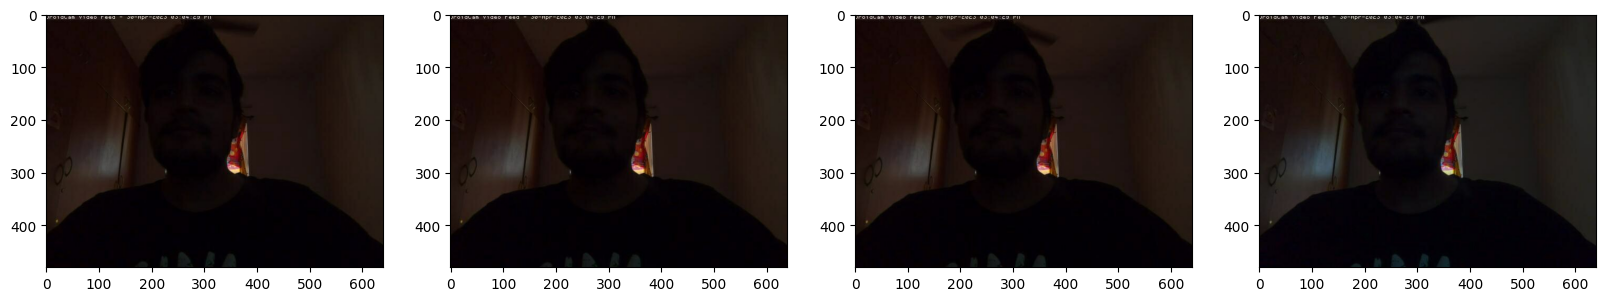

In [65]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

## 4. Partition Unaugmented Data

#### 4.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [41]:
# 120*.7 = 84 to train

In [66]:
# 120*.15 = 18 to val and test

### 4.2 Move Matching Labels AFTER Annotation with Labelme


In [67]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)  

## 5. Image Augmentation

In [9]:
import albumentations as alb

In [10]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                        keypoint_params=alb.KeypointParams(format='xy', label_fields=['class_labels']))

In [11]:
for partition in ['train', 'test', 'val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        classes = [0,0]
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
    
            if label['shapes'][0]['label']=='lefteye': 
                classes[0] = 1
                coords[0] = np.squeeze(label['shapes'][0]['points'])[0]
                coords[1] = np.squeeze(label['shapes'][0]['points'])[1]

            if label['shapes'][0]['label']=='righteye':
                classes[1] = 1
                coords[2] = np.squeeze(label['shapes'][0]['points'])[0]
                coords[3] = np.squeeze(label['shapes'][0]['points'])[1]

            if len(label['shapes']) > 1:     
                if label['shapes'][1]['label'] =='lefteye': 
                    classes[0] = 1 
                    coords[0] = np.squeeze(label['shapes'][1]['points'])[0]
                    coords[1] = np.squeeze(label['shapes'][1]['points'])[1]

                if label['shapes'][1]['label'] =='righteye': 
                    classes[1] = 1
                    coords[2] = np.squeeze(label['shapes'][1]['points'])[0]
                    coords[3] = np.squeeze(label['shapes'][1]['points'])[1]
            
            np.divide(coords, [640,480,640,480])
                
        try: 
            for x in range(60):
                keypoints = [(coords[:2]), (coords[2:])]
                augmented = augmentor(image=img, keypoints=keypoints, class_labels=['lefteye','righteye'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image
                annotation['class'] = [0,0]
                annotation['keypoints'] = [0,0,0,0]

                if os.path.exists(label_path):
                    if len(augmented['keypoints']) > 0: 
                        for idx, cl in enumerate(augmented['class_labels']):
                            if cl == 'lefteye': 
                                annotation['class'][0] = 1 
                                annotation['keypoints'][0] = augmented['keypoints'][idx][0]
                                annotation['keypoints'][1] = augmented['keypoints'][idx][1]
                            if cl == 'righteye': 
                                annotation['class'][1] = 1 
                                annotation['keypoints'][2] = augmented['keypoints'][idx][0]
                                annotation['keypoints'][3] = augmented['keypoints'][idx][1]
                                
                annotation['keypoints'] = list(np.divide(annotation['keypoints'], [450,450,450,450]))


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)